In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import shap
from torch.autograd import grad
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


def preds_and_grads(inputs, model, baselines, n_steps=500, target=1):
    """
    function to get predictions and gradients of the output wrt features values
    
    Args:
        inputs : Tensor of inputs
        model : pytorch model
        baselines : Tensor or None of baselines 
        n_steps : int number of steps to approximate integrated gradients
        target : int target class
        numpy : bool if true return numpy, else Tensor
    """
#    if inputs.dim() == 2:
#        inputs = inputs.unsqueeze(0)   
    if baselines == None:
        baselines = torch.zeros_like(inputs)
    
    # k/m in the formula
    alphas = torch.linspace(0, 1, n_steps).tolist()
    
    # direct path from baseline to input. shape : ([n_steps, n_features], )
    scaled_features = tuple(
            torch.cat(
                [baseline + alpha * (input - baseline) for alpha in alphas], dim=0
            ).requires_grad_()
            for input, baseline in zip(inputs, baselines)
        )
    
    # predictions at every step. shape : [n_steps, 1]
    preds = model(scaled_features[0])[:, target]
    # gradients of predictions wrt input features. shape : [n_steps, n_features]
    grads = grad(outputs=torch.unbind(preds), inputs=scaled_features)
    #weighted_grades = grads*(inputs - baselines)
    return preds, grads

def batch_integrated_gradients(inp_idx, data, time_steps, model, n_steps): 
    inp = []
    i=0
    while i <= time_steps:
        inp.append([data[inp_idx+i:inp_idx+i+1]])
        i += 1
    batch_gradients = []
    preds = []
    time_interval_gradients =[]
    for i in (range(len(inp)-1)): 
        a, b = preds_and_grads(inp[i+1], model, baselines=inp[i], n_steps=n_steps)
        batch_gradients.append(b[0].mean(0)*(np.array(inp[i+1][0]) - np.array(inp[i][0])))
        time_interval_gradients.append(b[0])
        preds.append(a)
    return batch_gradients, preds, time_interval_gradients#, batch_gradients_times_last #importance w.r.t last item in the list


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
dataset_path = "BreastCancer-SurvivalTime_TimeSeries.csv"
data = pd.read_csv(dataset_path)

data['Regimen Outcome Desc.'] = data['Regimen Outcome Desc.'].fillna('-1')
data['Ethnicity'] = data['Ethnicity'].fillna('A') #'A'
data['Performance'] = data['Performance'].fillna('1')
data['Height'] = data['Height'].fillna(-1) #1.57
data.loc[data['Height'] <= 1.5 ,'Height'] = -1 #1.57
data.loc[data['Height'] >= 2 ,'Height'] = -1 #1.70
data['Weight'] = data['Weight'].fillna(71.24)
data.loc[data['Weight'] <= 40 ,'Weight'] = 65
data.loc[data['Weight'] >= 100 ,'Weight'] = 71.24
data['CANCER PLAN'] = data['CANCER PLAN'].fillna('-1') #Curative
data['STATUS'] = data['STATUS'].fillna('Alive')
data['Chemo Radiation'] = data['Chemo Radiation'].fillna('N') #N
data['Behaviour'] = data['Behaviour'].fillna('-1') #Malginant
data.loc[data['Dose Administration'] <= 0 ,'Dose Administration'] = -1  #300
data['Dose Administration'] = data['Dose Administration'].fillna(-1) #500
data.loc[data['Dose Administration'] >= 3000 ,'Dose Administration'] = -1 #600
data['T Best'] = data['T Best'].fillna('3')  #3
data['N Best'] = data['N Best'].fillna('0')  #0
data['M Best'] = data['M Best'].fillna('0')
data['Admin Route'] = data['Admin Route'].fillna('-1') #intravenous
data['Regimen Time Delay'] = data['Regimen Time Delay'].fillna('0') #N
data['Regimen Stopped Early'] = data['Regimen Stopped Early'].fillna('0')
data['Clinical Trial'] = data['Clinical Trial'].fillna('N')
data['CNS'] = data['CNS'].fillna('Y1') #Y1
data['ACE'] = data['ACE'].fillna('9') #9

data = data.sort_values(['PATIENTID','Cycle Number'],ascending=True).groupby(data['PATIENTID']).head()

bc_data = data.loc[:,['Age','Sex', 'Site','Morph', 'Weight', 'Height', 'Dose Administration', 'Chemo Radiation', 'Regimen Outcome Desc.', 'Admin Route', 'Regimen Time Delay', 'Regimen Stopped Early', 'Cycle Number', 'Grade','CANCER PLAN','Ethnicity','Behaviour','CReg Code', 'T Best',  'N Best', 'M Best',
                'Laterality', 'CNS', 'ACE', 'Performance', 'Clinical Trial']].values

data['Survival Time'] = data['Survival Time'].replace('< 6 Months','0')
data['Survival Time'] = data['Survival Time'].replace('> 6 Months','1')
#data = data.drop(columns=['PATIENTID'])
target = data.loc[:,['Survival Time']].values

categorical_features = [1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25]


bc_data = bc_data.astype(str)
categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(bc_data[:, feature])
    bc_data[:, feature] = le.transform(bc_data[:, feature])
    categorical_names[feature] = le.classes_
encoder = OneHotEncoder().fit(bc_data) 


train_features, test_features, train_labels, test_labels = train_test_split(bc_data, target, 
                                                                                  shuffle=False, train_size=0.70)        

true_train_labels = []

for i in range(len(train_labels)):
    true_train_labels.append(int(train_labels[i][0]))
    
true_train_labels = np.array(true_train_labels).astype('int64')

true_test_labels = [] 

for i in range(len(test_labels)):
    true_test_labels.append(test_labels[i][0])
    
train_features = train_features.astype(float)
test_features = test_features.astype(float)

torch.manual_seed(1)  # Set seed for reproducibility.
n_input, n_hidden, n_out, batch_size, learning_rate = 26, 40, 2, 100, 0.01

input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(true_train_labels)
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)


In [4]:
data

,PATIENTID,Age,Ethnicity,Sex,Site,Morph,Weight,Height,Dose Administration,Regimen Outcome Desc.,...,CNS,Performance,Diagnosis Date,Vital Status Date,STATUS,date_correct,diff,> 6Months,< 6Months,Survival Time
3037,20000115,78,J,FEMALE,C50,8500,84.0,1.67,600.0,-1,...,Y1,1,2013-07-05 00:00:00,2015-04-12 00:00:00,Dead,True,646,True,False,1
1941,20000115,78,J,FEMALE,C50,8500,84.0,1.67,300.0,-1,...,Y1,1,2013-07-05 00:00:00,2015-04-12 00:00:00,Dead,True,646,True,False,1
3443,20000115,78,J,FEMALE,C50,8500,84.0,1.67,450.0,-1,...,Y1,1,2013-07-05 00:00:00,2015-04-12 00:00:00,Dead,True,646,True,False,1
3217,20000115,78,J,FEMALE,C50,8500,84.0,1.67,50.0,-1,...,Y1,1,2013-07-05 00:00:00,2015-04-12 00:00:00,Dead,True,646,True,False,1
12,20000160,79,A,FEMALE,C50,8500,61.0,-1.00,600.0,-1,...,Y1,9,2015-07-06 00:00:00,2015-10-18 00:00:00,Dead,True,104,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,20128440,82,A,FEMALE,C50,8500,73.8,-1.00,180.0,-1,...,99,1,2015-08-07 00:00:00,2015-09-21 00:00:00,Dead,True,45,False,True,0
1400,20128440,82,A,FEMALE,C50,8500,73.8,-1.00,8.0,-1,...,99,1,2015-08-07 00:00:00,2015-09-21 00:00:00,Dead,True,45,False,True,0
1396,20128440,82,A,FEMALE,C50,8500,73.8,-1.00,1.0,-1,...,99,1,2015-08-07 00:00:00,2015-09-21 00:00:00,Dead,True,45,False,True,0
1403,110027959,86,A,FEMALE,C50,8070,79.0,1.70,8.0,-1,...,Y1,0,2015-04-10 00:00:00,2015-09-14 00:00:00,Dead,True,157,False,True,0


In [27]:
torch.manual_seed(1)  # Set seed for reproducibility.
n_input, n_hidden, n_out, batch_size, learning_rate = 26, 20, 2, 100, 0.01

input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(true_train_labels)
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_out),
                      nn.Softmax()
                      )
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
input_tensor[0]

tensor([ 78.0000,   0.0000,   0.0000,   6.0000,  84.0000,   1.6700, 600.0000,
          0.0000,   0.0000,   5.0000,   3.0000,   1.0000,   1.0000,   2.0000,
          0.0000,   7.0000,   0.0000,   6.0000,   4.0000,   0.0000,   0.0000,
          0.0000,   3.0000,   4.0000,   1.0000,   4.0000])

In [7]:
losses = []
for epoch in range(5000):
    pred_y = model(input_tensor)
    loss = loss_function(pred_y, label_tensor)
    losses.append(loss.item())
    model.zero_grad()
    loss.backward()
    optimizer.step()

C:\Users\Jamie\anaconda3\envs\temporal-project-env\Lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [8]:
testIG = batch_integrated_gradients(0, input_tensor, 3, model, n_steps=100) #2-4 test

In [9]:
testIG[2]

[tensor([[-4.7962e-11, -2.4981e-09,  4.7369e-12,  ...,  3.8744e-11,
          -7.2631e-10, -5.8105e-10],
         [-4.3144e-11, -2.2472e-09,  4.2610e-12,  ...,  3.4852e-11,
          -6.5334e-10, -5.2268e-10],
         [-3.8889e-11, -2.0256e-09,  3.8408e-12,  ...,  3.1415e-11,
          -5.8891e-10, -4.7113e-10],
         ...,
         [-2.0543e-13, -2.0857e-12,  3.5466e-14,  ..., -8.9340e-13,
          -1.1221e-12, -5.5006e-13],
         [-4.4651e-13, -4.2210e-12,  6.1571e-14,  ..., -1.7045e-12,
          -1.9651e-12, -1.2432e-12],
         [-1.0158e-12, -8.8768e-12,  1.0396e-13,  ..., -3.3254e-12,
          -3.3677e-12, -2.9396e-12]]),
 tensor([[-1.0158e-12, -8.8768e-12,  1.0396e-13,  ..., -3.3254e-12,
          -3.3677e-12, -2.9396e-12],
         [-7.4292e-13, -6.7268e-12,  8.7684e-14,  ..., -2.6103e-12,
          -2.8189e-12, -2.1141e-12],
         [-5.5621e-13, -5.2310e-12,  7.5317e-14,  ..., -2.1021e-12,
          -2.4058e-12, -1.5531e-12],
         ...,
         [-3.7511e-17, -5

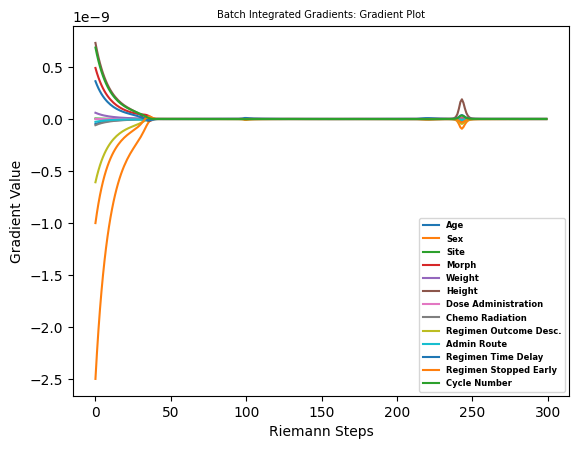

In [10]:
feature_names = ['Age','Sex', 'Site','Morph', 'Weight', 'Height', 'Dose Administration', 'Chemo Radiation', 'Regimen Outcome Desc.', 'Admin Route', 'Regimen Time Delay', 'Regimen Stopped Early', 'Cycle Number', 'Grade','CANCER PLAN','Ethnicity','Behaviour','CReg Code', 'T Best',  'N Best', 'M Best',
                'Laterality', 'CNS', 'ACE', 'Performance', 'Clinical Trial']

def BatchIG_GradientPlot(tensor_data, feature_names, feature_indices):
    # Accumulate data from each tensor
    all_data = [[] for _ in feature_indices]
    
    for tensor in tensor_data:
        # Transpose the tensor to get columns as separate arrays
        transposed_tensor = tensor.T
        
        # Iterate over the selected feature indices
        for i, index in enumerate(feature_indices):
            all_data[i].extend(transposed_tensor[index])

    # Plot accumulated data
    for i, data in enumerate(all_data):
        plt.plot(data, label=feature_names[feature_indices[i]])

    plt.rcParams.update({'font.size': 6, 'font.weight': 'bold'})
    # Add legend and labels for all tensors
    plt.legend()
    plt.xlabel('Riemann Steps')
    plt.ylabel('Gradient Value')
    plt.title('Batch Integrated Gradients: Gradient Plot')
    # Show the plot
    plt.show()

# Example usage:
# Suppose you want to plot features at indices 0, 1, and 2
selected_feature_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12]
BatchIG_GradientPlot(testIG[2], feature_names, selected_feature_indices)

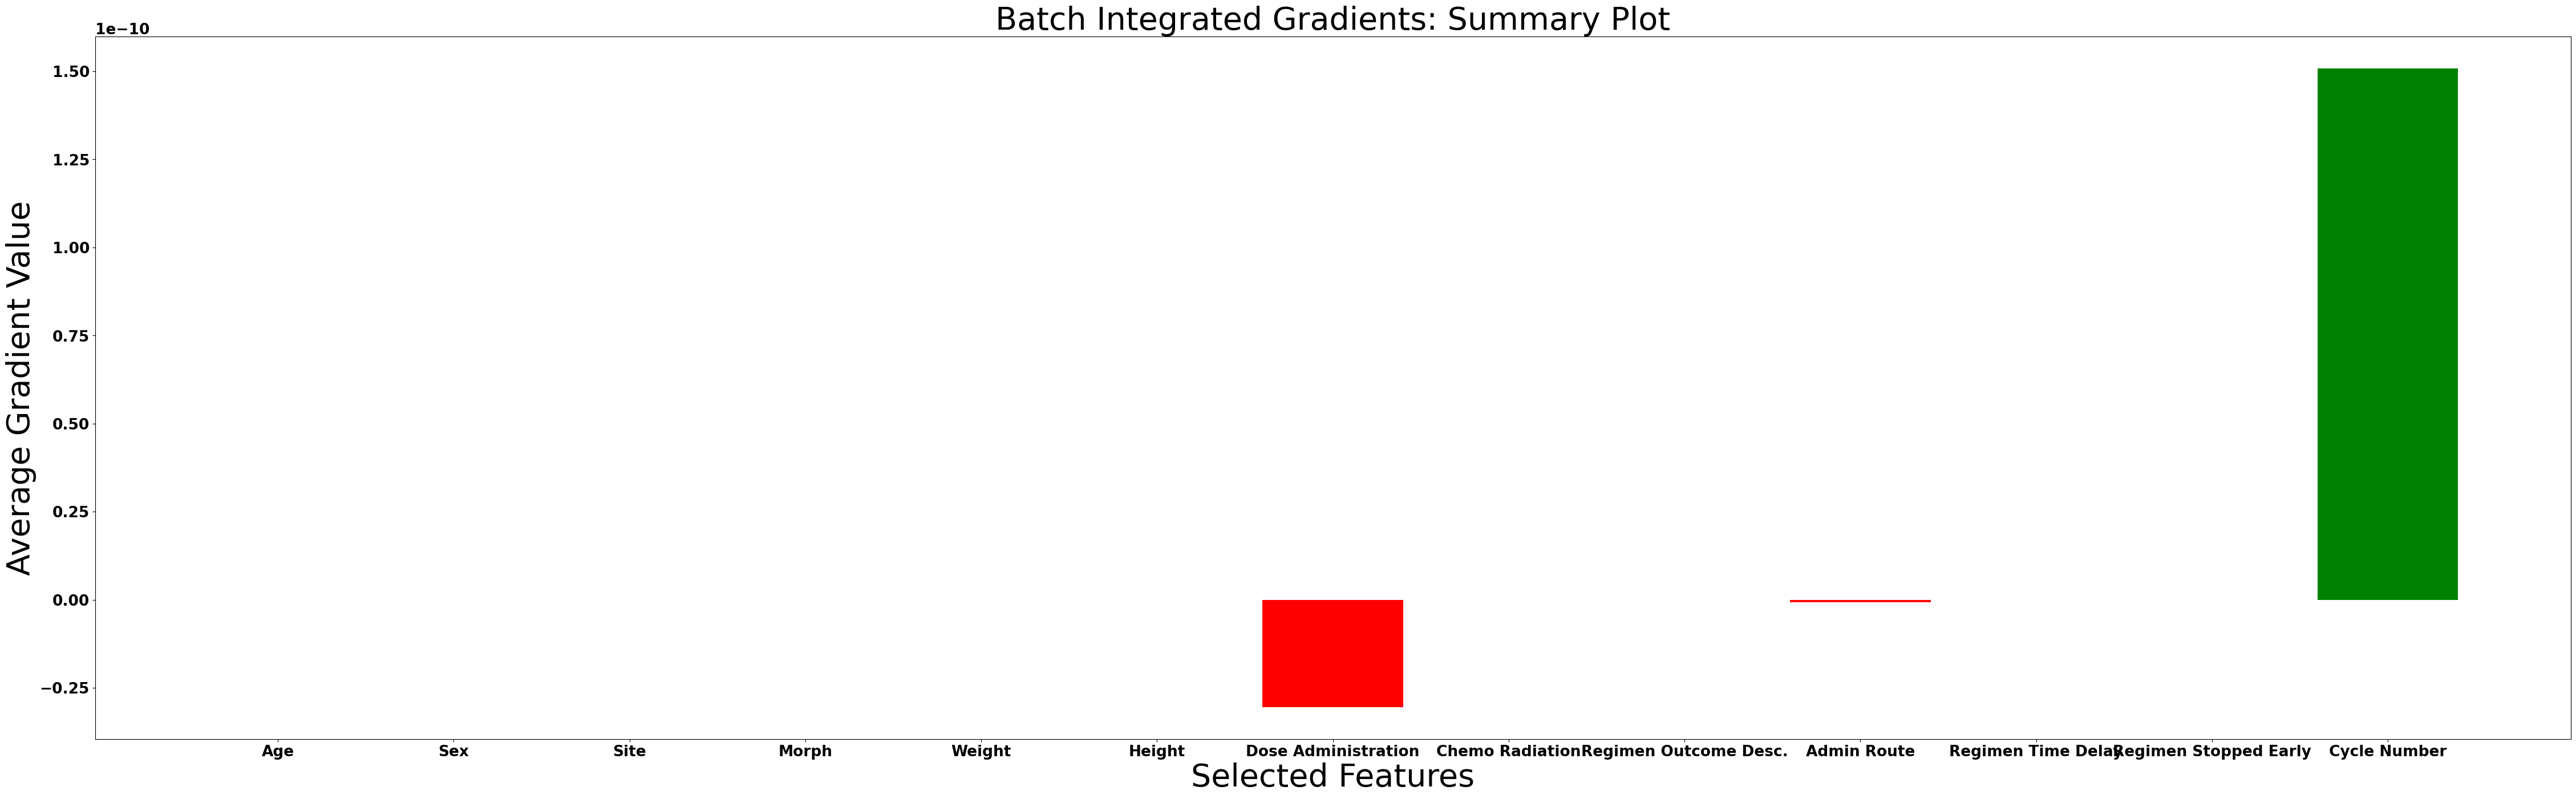

In [11]:
def BatchIG_SummaryPlot(tensor_data, feature_names, feature_indices):
    # Accumulate average values for each feature
    average_values = []
    colors = []
    
    for index in feature_indices:
        feature_data = []
        for tensor in tensor_data:
            # Transpose the tensor to get columns as separate arrays
            transposed_tensor = tensor.T
            feature_data.extend(transposed_tensor[index])
        # Calculate the average value for the feature
        average_value = np.sum(feature_data)
        average_values.append(average_value)
        
        # Assign color based on the sign of the average value
        if average_value >= 0:
            colors.append('green')
        else:
            colors.append('red')

    plt.rcParams.update({'font.size': 19, 'font.weight': 'bold'})
    plt.figure(figsize=(56,16))
    
    # Plot average values in a bar chart
    plt.bar(np.arange(len(feature_indices)), average_values, color=colors, tick_label=[feature_names[i] for i in feature_indices])
    
    # Add labels and title
    plt.xlabel('Selected Features',fontsize=40)
    plt.ylabel('Average Gradient Value',fontsize=40)
    plt.title('Batch Integrated Gradients: Summary Plot',fontsize=40)
    
    # Show the plot
    plt.show()

# Example usage:
# Suppose you want to plot average values for features at indices 0, 1, and 2
selected_feature_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12]
BatchIG_SummaryPlot(testIG[0], feature_names, selected_feature_indices)

In [16]:
class BatchIntegratedGradients:
    def __init__(self, model):
        self.model = model

    def preds_and_grads(self, inputs, baselines=None, n_steps=500, target=1):
        if baselines is None:
            baselines = torch.zeros_like(inputs)

        alphas = torch.linspace(0, 1, n_steps).tolist()

        scaled_features = tuple(
            torch.cat(
                [baseline + alpha * (input - baseline) for alpha in alphas], dim=0
            ).requires_grad_()
            for input, baseline in zip(inputs, baselines)
        )

        preds = self.model(scaled_features[0])[:, target]
        grads = grad(outputs=torch.unbind(preds), inputs=scaled_features)

        return preds, grads

    def BatchIG_Values(self, inp_idx, data, time_steps, n_steps):
        inp = []
        i = 0
        while i <= time_steps:
            inp.append([data[inp_idx + i : inp_idx + i + 1]])
            i += 1
        batch_gradients = []
        preds = []
        time_interval_gradients = []
        for i in range(len(inp) - 1):
            a, b = self.preds_and_grads(inp[i + 1], baselines=inp[i], n_steps=n_steps)
            batch_gradients.append(b[0].mean(0) * (np.array(inp[i + 1][0]) - np.array(inp[i][0])))
            time_interval_gradients.append(b[0])
            preds.append(a)
        return batch_gradients, preds, time_interval_gradients

    @staticmethod
    def SummaryPlot(tensor_data, feature_names, feature_indices):
        average_values = []
        colors = []
        for index in feature_indices:
            feature_data = []
            for tensor in tensor_data:
                transposed_tensor = tensor.T
                feature_data.extend(transposed_tensor[index])
            average_value = np.sum(feature_data)
            average_values.append(average_value)
            if average_value >= 0:
                colors.append('green')
            else:
                colors.append('red')

        plt.rcParams.update({'font.size': 19, 'font.weight': 'bold'})
        plt.figure(figsize=(56, 16))
        plt.bar(np.arange(len(feature_indices)), average_values, color=colors,
                tick_label=[feature_names[i] for i in feature_indices])
        plt.xlabel('Selected Features', fontsize=40)
        plt.ylabel('Average Gradient Value', fontsize=40)
        plt.title('Batch Integrated Gradients: Summary Plot', fontsize=40)
        plt.show()

    @staticmethod
    def BGradientPlot(tensor_data, feature_names, feature_indices):
        all_data = [[] for _ in feature_indices]
        for tensor in tensor_data:
            transposed_tensor = tensor.T
            for i, index in enumerate(feature_indices):
                all_data[i].extend(transposed_tensor[index])

        for i, data in enumerate(all_data):
            plt.plot(data, label=feature_names[feature_indices[i]])

        plt.rcParams.update({'font.size': 6, 'font.weight': 'bold'})
        plt.legend()
        plt.xlabel('Riemann Steps')
        plt.ylabel('Gradient Value')
        plt.title('Batch Integrated Gradients: Gradient Plot')
        plt.show()

In [17]:
batch_integrated_gradients = BatchIntegratedGradients(model)

In [19]:
batch_ig_values = batch_integrated_gradients.BatchIG_Values(0, input_tensor, 3, 100)

In [23]:
feature_names = ['Age','Sex', 'Site','Morph', 'Weight', 'Height', 'Dose Administration', 'Chemo Radiation', 'Regimen Outcome Desc.', 'Admin Route', 'Regimen Time Delay', 'Regimen Stopped Early', 'Cycle Number', 'Grade','CANCER PLAN','Ethnicity','Behaviour','CReg Code', 'T Best',  'N Best', 'M Best',
                'Laterality', 'CNS', 'ACE', 'Performance', 'Clinical Trial']

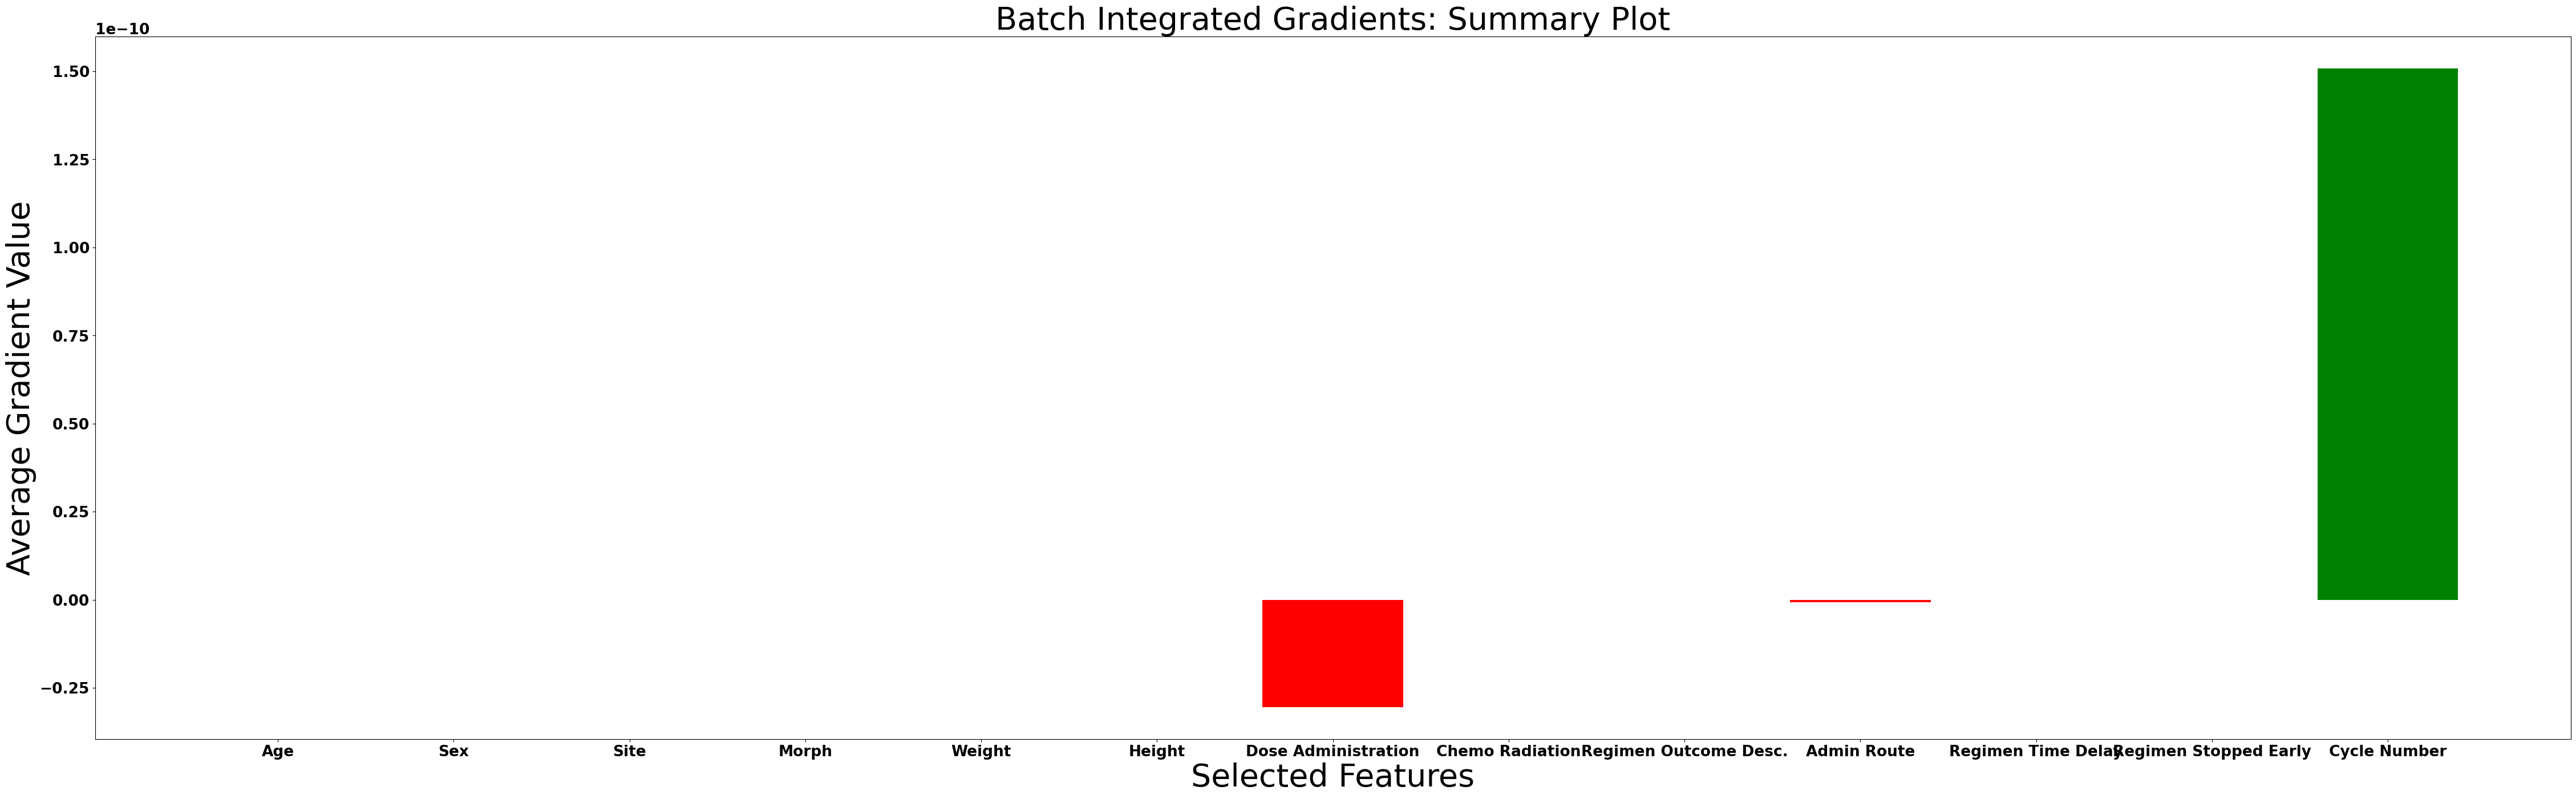

In [25]:
batch_integrated_gradients.SummaryPlot(batch_ig_values[0], feature_names, selected_feature_indices)

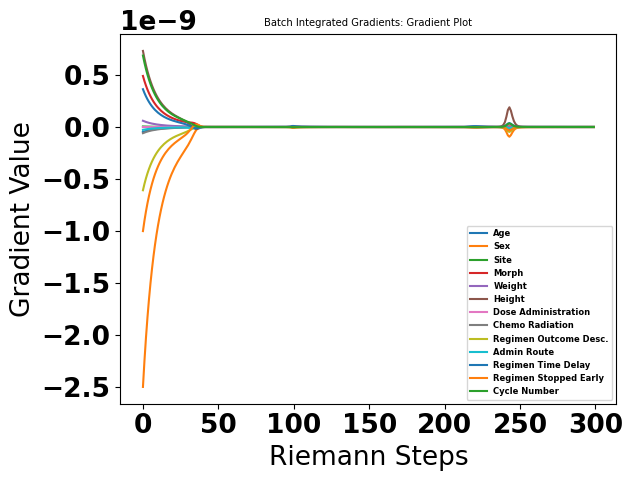

In [26]:
batch_integrated_gradients.GradientPlot(batch_ig_values[2], feature_names, selected_feature_indices)

In [46]:
explainer = shap.DeepExplainer(model, input_tensor)

In [81]:
shap_values_1 = explainer.shap_values(input_tensor[1:2])

In [82]:
shap_values_1

[array([[-4.08788677e-03, -1.37856705e-06,  0.00000000e+00,
          7.67021556e-05,  1.03500616e-02, -1.14002847e-04,
          1.62031613e-02,  0.00000000e+00,  1.55355272e-04,
          4.95973090e-03,  1.98611539e-04,  9.18672504e-06,
         -8.88422318e-03,  5.96679856e-05, -4.49115224e-03,
         -1.24230366e-02,  1.00348657e-07,  1.69963622e-03,
         -2.43447302e-03,  4.40949545e-04,  1.25761405e-02,
          4.46922168e-05,  2.06900717e-04,  1.63615390e-03,
         -2.89240312e-02,  1.79955456e-02]]),
 array([[ 2.72712950e-03, -6.11528492e-07,  0.00000000e+00,
         -3.32247582e-05,  1.34567672e-03, -4.91576566e-06,
         -8.97989795e-03,  0.00000000e+00, -2.23717681e-04,
         -4.84913835e-05,  3.80766141e-05, -4.99686166e-06,
          8.84666224e-05,  7.21950200e-05, -8.67647905e-05,
         -6.22836989e-04, -7.15511845e-08,  4.45415717e-05,
          1.39293683e-04,  2.38600187e-04,  4.55866029e-05,
         -4.23799283e-05, -1.30817743e-05, -1.15506964

In [83]:
shap_values_2 = explainer.shap_values(input_tensor[2:3])

In [127]:
explainer.expected_value[1] 

0.569818

In [126]:
(explainer.expected_value[1] +((shap_values_2[1]))) - (explainer.expected_value[1] + ((shap_values_1[1])))

array([[ 3.59568279e-04,  1.49225178e-06,  0.00000000e+00,
         5.83880319e-06,  1.48964243e-03, -6.21016684e-05,
         7.60387629e-04,  0.00000000e+00,  1.40259988e-04,
         1.41107834e-04,  1.44648220e-06, -4.36965320e-06,
        -9.93785543e-05, -3.35124823e-05,  2.59911976e-05,
         8.55580191e-04,  3.48051366e-08, -1.56322123e-04,
        -4.26137194e-05, -3.34678938e-04, -5.40072142e-06,
         3.83266861e-05, -1.33663843e-05, -1.34015036e-05,
        -6.36921322e-05, -3.03085617e-04]])

In [106]:
(explainer.expected_value[0] +((shap_values_2[1])))

array([[0.43326868, 0.43018286, 0.43018198, 0.43015459, 0.4330173 ,
        0.43011496, 0.42196247, 0.43018198, 0.43009852, 0.4302746 ,
        0.4302215 , 0.43017261, 0.43017107, 0.43022066, 0.43012121,
        0.43041472, 0.43018194, 0.4300702 , 0.43027866, 0.4300859 ,
        0.43022217, 0.43017793, 0.43015553, 0.43015703, 0.43006651,
        0.4300113 ]])

In [110]:
((shap_values_1[1]))

array([[ 2.72712950e-03, -6.11528492e-07,  0.00000000e+00,
        -3.32247582e-05,  1.34567672e-03, -4.91576566e-06,
        -8.97989795e-03,  0.00000000e+00, -2.23717681e-04,
        -4.84913835e-05,  3.80766141e-05, -4.99686166e-06,
         8.84666224e-05,  7.21950200e-05, -8.67647905e-05,
        -6.22836989e-04, -7.15511845e-08,  4.45415717e-05,
         1.39293683e-04,  2.38600187e-04,  4.55866029e-05,
        -4.23799283e-05, -1.30817743e-05, -1.15506964e-05,
        -5.17782537e-05,  1.32409623e-04]])

In [123]:

import imgkit# Visualize the SHAP values for the first sample
force_plot = shap.force_plot(explainer.expected_value[1], shap_values_1[1], feature_names=feature_names)

display(force_plot)

# Save the force plot as an image (by saving the HTML and rendering it)
force_plot_html = shap.save_html('force_plot1.html', force_plot)

In [124]:
# Visualize the SHAP values for the second sample
force_plot = shap.force_plot(explainer.expected_value[1], shap_values_2[1], feature_names=feature_names)


display(force_plot)

# Save the force plot as an image (by saving the HTML and rendering it)
force_plot_html = shap.save_html('force_plot2.html', force_plot)
